# Bidimensional boundary element method

This examples uses BEM_base to solve the Helmholtz and Laplace equations in bidimensional space using polynomial shape functions and NURBS curves to describe the boundary and interpolate domain variables (velocity potential and its flux for the Helmholtz equation and temperature and its flux for the Laplace equation). The first example which will be solved is acoustic duct problem, which has an analytical solution. If both ends of the acoustic duct are closed, then a Neumann boundary condition ($q = \bar{q}$) must be applied to every element. Let the boundary condition of the wall in one of the extremities not be null and that extremity will act as a piston. The analytical resonance frequencies for such a duct are given by
\begin{equation}
    F_{closed\ duct}\ (n,L) = \frac{\pi\ n\ c}{L}
\end{equation}
where $c$ is the wave propagation speed, $n=0,1,2,...$ is the mode number and $L$ is the length of the duct. The frequency is in rad/s, divide it to $2\ pi$ to obtain the frequency in Hz. The duct which will be studied has length = 100 mm and diameter = 10 mm. The speed of sound is $c = 343$ m/s and only the first non-zero mode will be studied ($n=1$).


In [3]:
c = 343*1000 # Speed of propagation in mm/s
F_closed(n,L,c) = pi*n*c/L # Analytical resonance frequency in rad/s
for n=1:3
    println("Mode n = $(n), L = $(L=100) m, F = $(F_closed(n,L,c)/(2*pi)) Hz.")
end

Mode n = 1, L = 100 m, F = 1715.0 Hz.
Mode n = 2, L = 100 m, F = 3430.0 Hz.
Mode n = 3, L = 100 m, F = 5145.0 Hz.


To solve this problem using constant bidimensional elements, the geometry must be described to BEM_base. Initially, the module for the constant bidimensional element will be loaded.

In [4]:
using SpecialFunctions
using KrylovMethods
include("../src/const2D/dep.jl") # Includes the dependencies
include("../src/const2D/beminterp.jl") # H-Matrices using Lagrange polynomial interpolation
include("../src/const2D/ACA.jl") # H-Matrices using ACA
include("../src/const2D/H_mat.jl") # H-Matrices using ACA


function solve(info,PONTOS_int,fc,BCFace,k)
## CBIE - Conventional Boundary Integral Equation
	NOS_GEO,NOS,ELEM,CDC = info;
	nnos = size(NOS,1)  # Number of physical nodes, same as elements when using constant elements
	b1 = 1:nnos # Array containing all the indexes for nodes and elements which will be used for integration
	# Gaussian quadrature - generation of points and weights [-1,1]
	npg=6; # Number of integration points
	qsi,w = Gauss_Legendre(-1,1,npg) # Generation of the points and weights
	println("Building A and b matrices using the traditional colocation BEM for constant elements.")
	@time A,b = cal_Aeb(b1,b1, [NOS,NOS_GEO,ELEM,fc,qsi,w,CDC,k])  # Builds A and B matrices using the collocation technique and applying the boundary conditions
	x = A\b # Solves the linear system
	phi,qphi = monta_phieq(CDC,x) # Applies the boundary conditions to return the velocity potential and flux
	println("Evaluating values at domain points.")
	@time phi_pint = calc_phi_pint(PONTOS_int,NOS_GEO,ELEM,phi,qphi,fc,fc,qsi,w,k) # Evaluates the value at domain points
return phi, qphi, phi_pint, phi_pint
end

function solveH(info,PONTOS_int,fc,BCFace,k)
## H-Matrix BEM - Interpolation using Lagrange polynomial
	NOS,NOS_GEO,ELEM,CDC = info;
	println("Building Tree and blocks using H-Matrices.")
	@time Tree,block = cluster(NOS[:,2:3],floor(sqrt(length(NOS))),2)
	# Gaussian quadrature - generation of points and weights [-1,1]
	npg=6; # Number of integration points
	qsi,w = Gauss_Legendre(-1,1,npg) # Generation of the points and weights
	println("Building A and b matrices using H-Matrix with interpolation.")
	@time Ai,bi = Hinterp(Tree,block,[NOS,NOS_GEO,ELEM,fc,qsi,w,CDC,k])
	xi = gmres(vet->matvec(Ai,vet,block,Tree),bi,5,tol=1e-5,maxIter=1000,out=0) #GMRES nas matrizes do ACA
	phii,qphii = monta_phieq(CDC,xi[1]) # Applies the boundary conditions to return the velocity potential and flux
	println("Evaluating values at internal points.")
	@time phi_pinti = calc_phi_pint(PONTOS_int,NOS_GEO,ELEM,phii,qphii,fc,fc,qsi,w,k) # Evaluates the value at internal (or external) points
return phii,qphii,phi_pinti,phi_pinti
end

solveH (generic function with 1 method)

In [5]:
# First, include the module const2D
#include("../src/const2D/const2D.jl")
#using const2D
## Now, to define a new geometry, first one must declare the points,
# segments, boundary conditions, etc...
n = 2; # Mode number
L = 100; # Length of the duct in mm
d = 10; # Diameter of the duct in mm
c = 343*1000; # Speed of wave propagation in mm/s
k = F_closed(n,L,c)/c; # Resonance wave number
points = [1 0 0; 2 L 0; 3 L d; 4 0 d];
segments = [1 1 2 0; 2 2 3 0; 3 3 4 0; 4 4 1 0];
ne = 10; # Number of element per segment
MESH = [1 ne; 2 ne; 3 ne; 4 ne];
BCFace = [1 1 0; 2 1 0; 3 1 0; 4 0 1]; # Face 4 will act like a piston
fc = [0];
# Apply the discretization technique and builds the problems matrices
#for the geometrical points, physical nodes, elements' connectivity and
#boundary conditions
info = format_dad(points,segments,MESH,BCFace);
# Now, the domain points will be created
n_pint = 100
PONTOS_int = zeros(n_pint,3)
for i = 1:n_pint
	PONTOS_int[i,:] = [i ((100-0.1)/n_pint)*i d/2]
end
u,q,uint,qint = solve(info,PONTOS_int,fc,BCFace,k);
#uH,qH,uintH,qintH = solveH(info,PONTOS_int,fc,BCFace,k);


Building A and b matrices using the traditional colocation BEM for constant elements.
  1.271058 seconds (571.34 k allocations: 21.154 MiB, 1.38% gc time)
Evaluating values at domain points.
  1.438374 seconds (1.17 M allocations: 35.866 MiB, 1.84% gc time)
Building Tree and blocks using H-Matrices.
  3.506752 seconds (849.61 k allocations: 40.194 MiB, 1.25% gc time)
Building A and b matrices using H-Matrix with interpolation.
  2.136733 seconds (629.25 k allocations: 28.763 MiB, 0.84% gc time)
gmres iterated maxIter (=1000) times without achieving the desired tolerance.
Evaluating values at internal points.
  0.084115 seconds (596.12 k allocations: 11.863 MiB, 6.88% gc time)


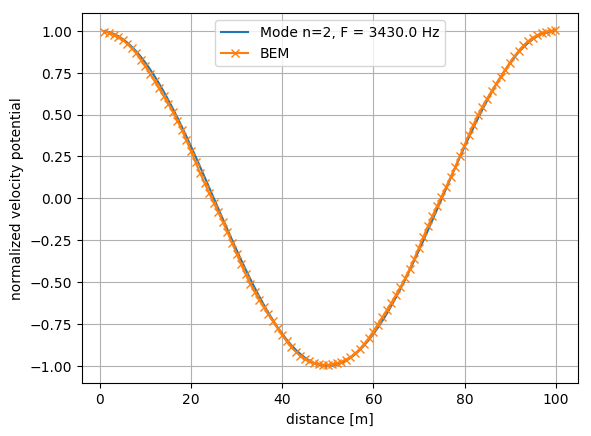

In [7]:
# Comparing the results
using PyPlot

phi_closed(x,n,L,c) = cos.(n*pi*(x./L))
figure()
plot(PONTOS_int[:,2],phi_closed(PONTOS_int[:,2],n,L,c),label="Mode n=$(n), F = $(F_closed(n,L,c)/(2*pi)) Hz")
hold(1)
plot(PONTOS_int[:,2],real.(uint),label="BEM",marker="x")
#plot(PONTOS_int[:,2],real.(uintH),label="H-BEM",marker="<")

legend()
xlabel("distance [m]")
ylabel("normalized velocity potential")
grid(1)
hold(0)